In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
import statistics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.layers.core import Dense, Activation, Dropout
import time  # helper libraries

from dataset_window import Dataset


def convertCash(cash):
	cash = cash.replace('.', '')
	cash = cash.replace(',', '.')
	return float(cash)

def clearNanMM(moving_average, price):
        moving_average[0] = price[0]
        moving_average[1] = (price[0] + price[1])/2
        moving_average[2] = (price[0] + price[1] + price[2])/3
        return moving_average;


def create_dataset(dataset, look_back=1):
	dataX, dataY = [], [] 
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])

	return np.array(dataX), np.array(dataY)

#Carregando os dados
data = pd.read_csv("Preços semanais_com_chuva.csv")
data['DATA'] = pd.to_datetime(data.DATA, format='%d/%m/%y')
data.set_index('DATA', inplace=True)
index = data.index.values
# print(index)
# data['PREÇO'] = data['PREÇO'].apply(convertCash)
data['PREÇO_DOLAR'] = data['PREÇO_DOLAR'].apply(convertCash)

import talib as ta

data['MEDIA_MOVEL'] = ta.EMA(data['PREÇO'], timeperiod=4)
data['MEDIA_MOVEL'] = clearNanMM(data['MEDIA_MOVEL'], data['PREÇO'])

<ipython-input-1-2125483908d9>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moving_average[0] = price[0]
<ipython-input-1-2125483908d9>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moving_average[1] = (price[0] + price[1])/2
<ipython-input-1-2125483908d9>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moving_average[2] = (price[0] + price[1] + price[2])/3


In [2]:
scaler_price = MinMaxScaler(feature_range=(0,1))
scaler_dollar = MinMaxScaler(feature_range=(0,1))
scaler_rain = MinMaxScaler(feature_range=(0,1))
scaler_media_movel = MinMaxScaler(feature_range=(0,1))
data['PREÇO'] = scaler_price.fit_transform(data['PREÇO'].to_numpy().reshape(-1, 1))
data['PREÇO_DOLAR'] = scaler_dollar.fit_transform(data['PREÇO_DOLAR'].to_numpy().reshape(-1, 1))
data['MEDIA_MOVEL'] = scaler_dollar.fit_transform(data['MEDIA_MOVEL'].to_numpy().reshape(-1, 1))
data['CHUVA'] = scaler_rain.fit_transform(data['CHUVA'].to_numpy().reshape(-1, 1))

In [3]:
window = 4
shape_dataset = 154
epochs = 1000

x,y = create_dataset(data.values, window)
print(x.shape)

(205, 4, 4)


In [4]:
train_x, test_x = x[0:shape_dataset, :], x[shape_dataset:, :]

train_y, test_y = y[0:shape_dataset], y[shape_dataset:]

print(test_y.shape)

(51,)


In [5]:
model = Sequential()
model.add(LSTM(25, input_shape=(4, 4)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(train_x, train_y, epochs=epochs, verbose=1)

trainPredict = model.predict(train_x)
testPredict = model.predict(test_x)

model.save('price_model')

Epoch 1/1000
5/5 [==============================] - 2s 5ms/step - loss: 0.1030
Epoch 2/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.0639
Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.0521
Epoch 4/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0327
Epoch 5/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.0290
Epoch 6/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0199
Epoch 7/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0217
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0236
Epoch 9/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0164
Epoch 10/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.0155
Epoch 11/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0183
Epoch 12/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0162
Epoch 13/1000
5/5 [=============================

INFO:tensorflow:Assets written to: price_model/assets


INFO:tensorflow:Assets written to: price_model/assets


In [6]:
trainPredict = model.predict(train_x)
testPredict = model.predict(test_x)

In [7]:
trainPredict = scaler_price.inverse_transform(trainPredict)
train_y = scaler_price.inverse_transform([train_y])

testPredict = scaler_price.inverse_transform(testPredict)
test_y = scaler_price.inverse_transform([test_y])

In [8]:
#calculate mean absolute error
mape_train = mean_absolute_percentage_error(train_y[0], trainPredict)
print('Train Score: %.2f MAPE' % (mape_train))
mape_test = mean_absolute_percentage_error(test_y[0], testPredict)
print('Test Score: %.2f MAPE' % (mape_test))
print('\n -----------------------------------------\n')
#calculate mean absolute error
mae_train = mean_absolute_error(train_y[0], trainPredict)
print('Train Score: %.2f MAE' % (mae_train))
mae_test = mean_absolute_error(test_y[0], testPredict)
print('Test Score: %.2f MAE' %(mae_test))
print('\n -----------------------------------------\n')
# calculate root mean squared error
rmse_train = math.sqrt(mean_squared_error(train_y[0], trainPredict))
print('Train Score: %.2f RMSE' % (rmse_train))
rmse_test = math.sqrt(mean_squared_error(test_y[0], testPredict))
print('Test Score: %.2f RMSE' % (rmse_test))

Train Score: 0.15 MAPE
Test Score: 0.15 MAPE

 -----------------------------------------

Train Score: 3.74 MAE
Test Score: 6.56 MAE

 -----------------------------------------

Train Score: 5.15 RMSE
Test Score: 8.97 RMSE


In [9]:
import talib as ta

mma = ta.EMA(testPredict.reshape(-1).astype('double'), timeperiod = 4)

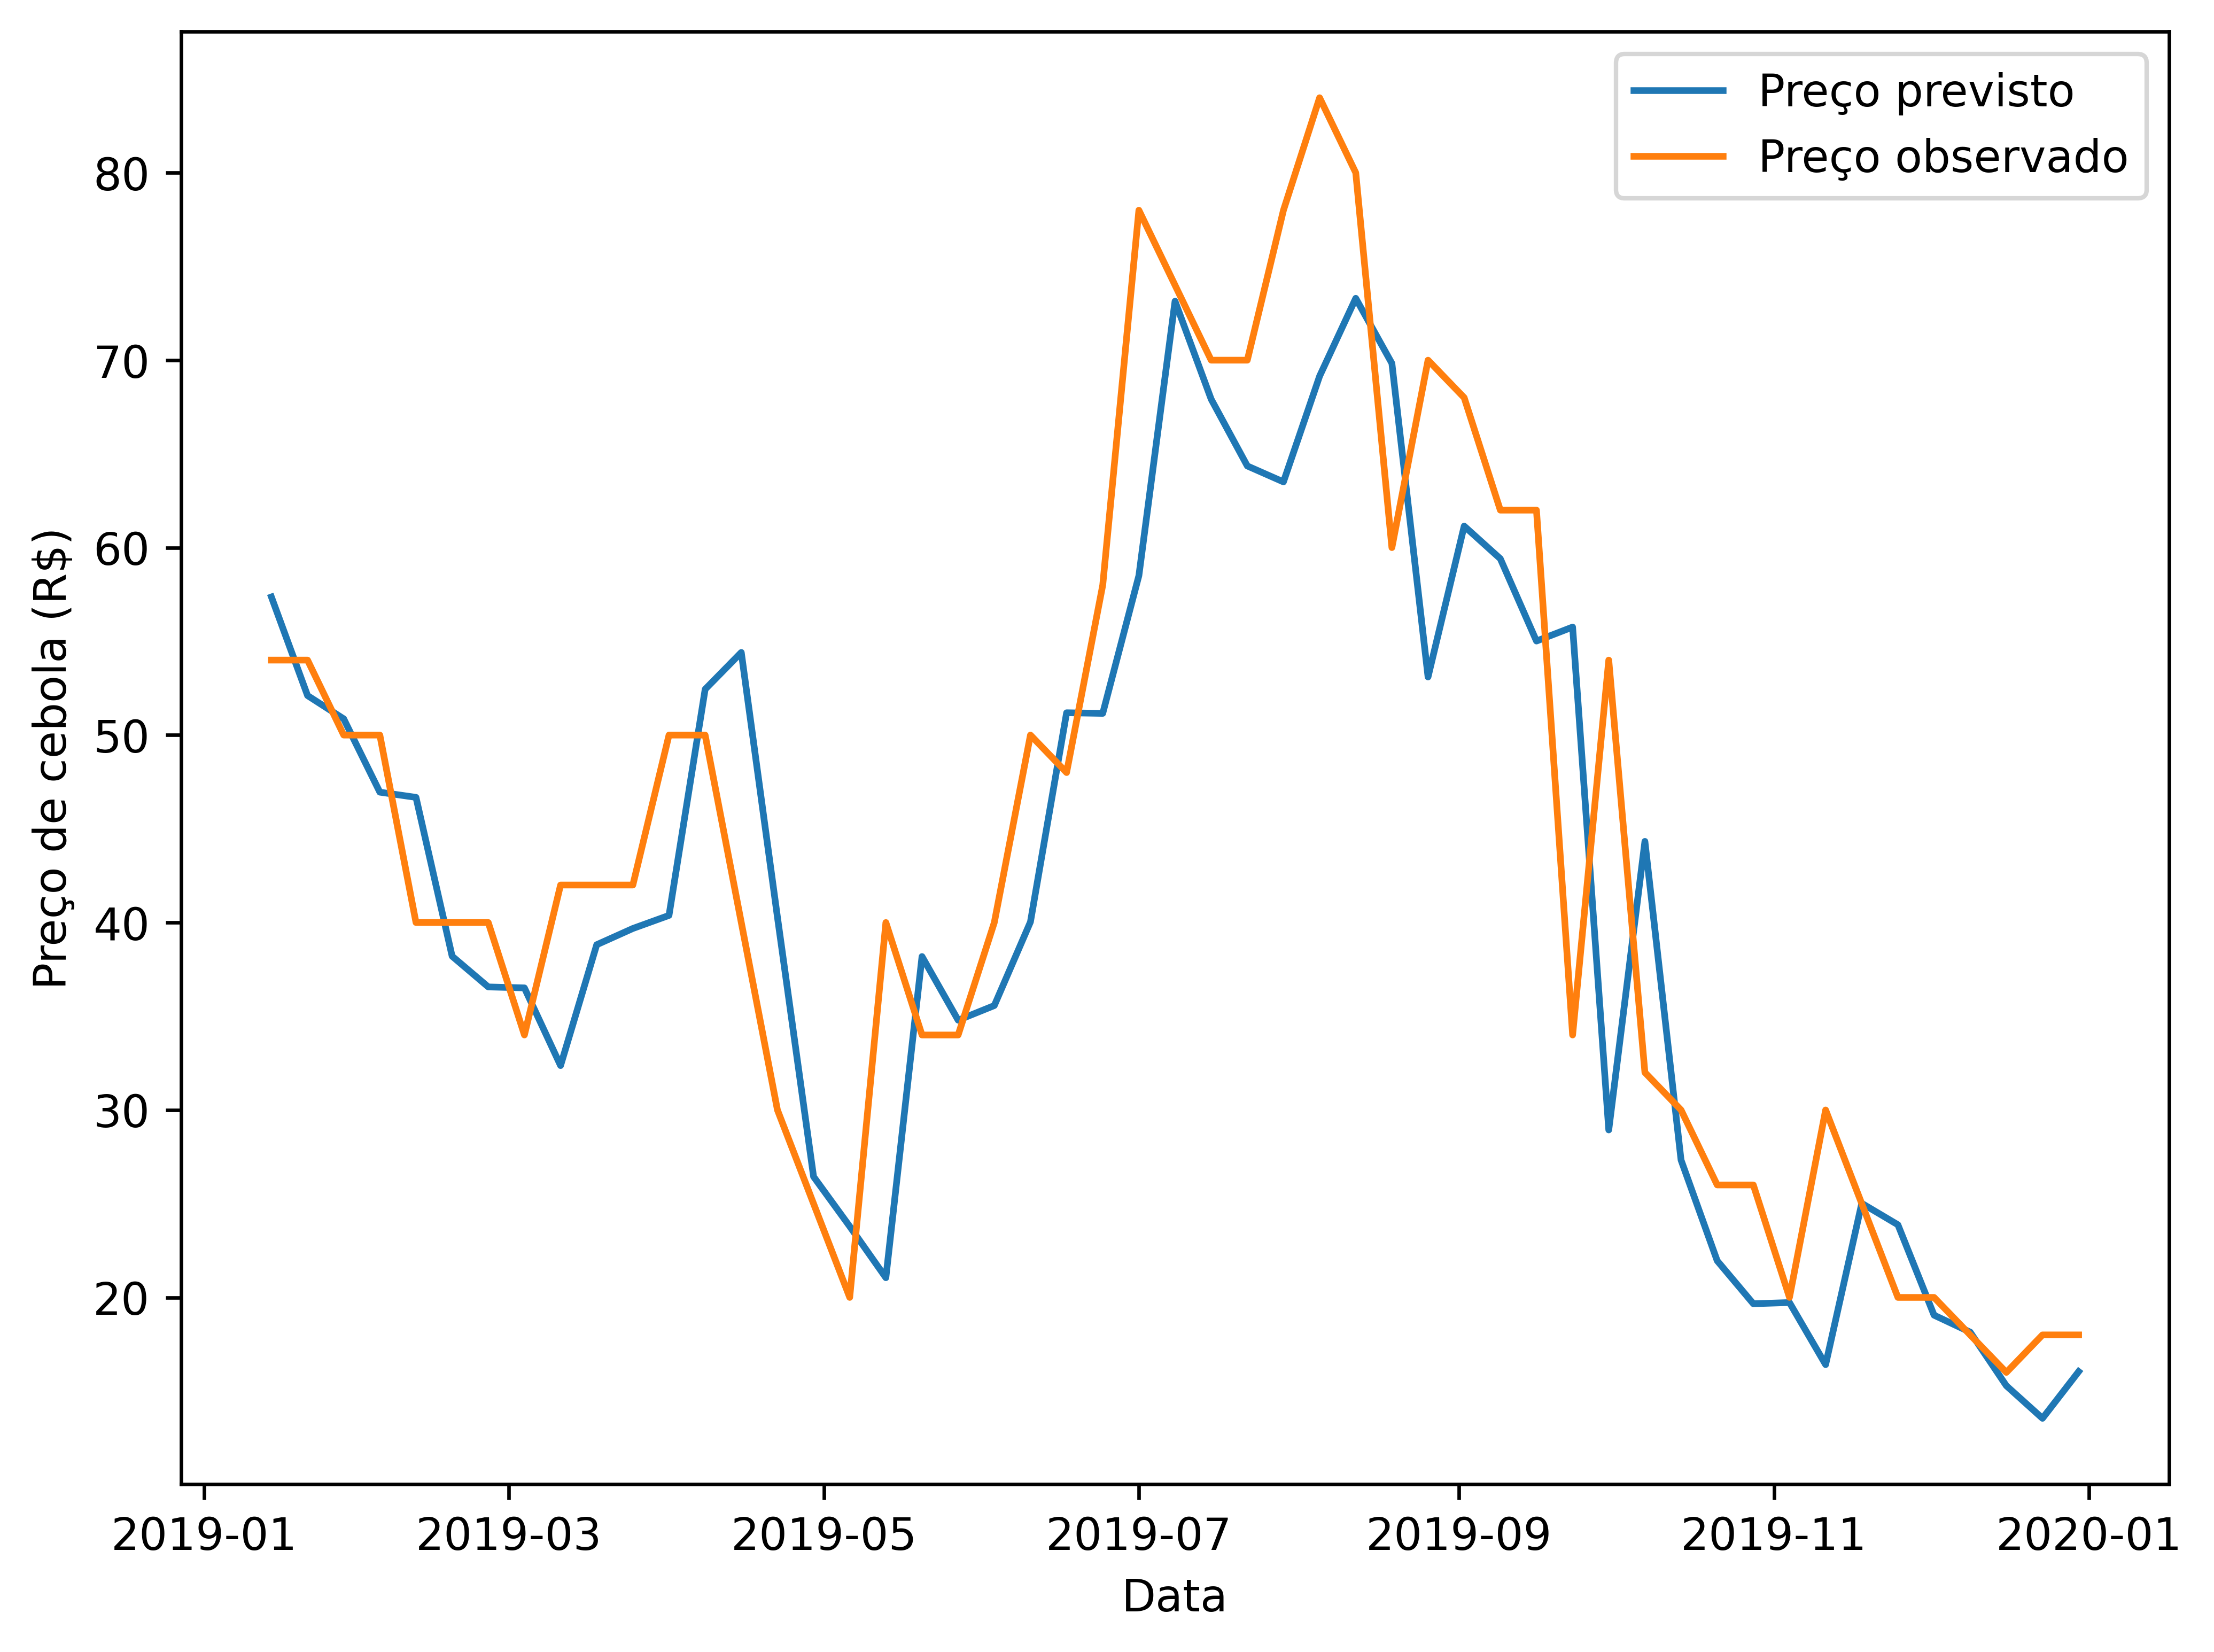

In [10]:
fig = plt.figure(figsize=(8, 6), dpi=600)
plt.plot(index[158:], testPredict, label='Preço previsto')
plt.plot(index[158:], test_y.reshape(-1, 1), label='Preço observado')
# plt.plot(index[158:], mma, label="Média móvel")
plt.legend()
plt.ylabel('Preço de cebola (R$)')
plt.xlabel('Data')
plt.show()
fig.savefig('rain_predict.png')